In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Problem statement

Consider the dynamical system
$$\begin{align}
    x_{t+1} {}={} & A x_t + G w_t,
    \\
    y_t {}={}     & C x_t + v_t.
\end{align}$$
Using only measurements of the system output we want to estimate the system states.

**Assumptions:**
1. $w_t\overset{\text{iid}}{\sim} \mathcal{N}(0, Q)$, where $Q\succeq 0$
2. $v_t\overset{\text{iid}}{\sim} \mathcal{N}(0, R)$, where $R\succ 0$
3. $x_0\sim \mathcal{N}(\tilde{x}_0, P_0)$
4. $x_0$, $(w_t)_t$ and $(v_t)_t$ are independent

Matrices $A$, $G$, $C$, $Q$, and $R$ are known

## Preliminaries



Keep in mind throughout this notebook:

1. The expectation is linear, i.e., ${\rm I\!E}[X+Y]={\rm I\!E}[X]+{\rm I\!E}[Y]$ for random variables $X$ and $Y$
2. and ${\rm I\!E}[AX] = A{\rm I\!E}[X]$, where $A$ is a constant matrix (not random)
2. The variance is **not** linear, **but** if $X$ and $Y$ are independent, then ${\rm Var}[X+Y] = {\rm Var}[X] + {\rm Var}[Y]$
3. and ${\rm Var}[AX] = A{\rm Var}[X]A^\intercal$, where $A$ a constant matrix (not random)

The covariance is *bilinear*, i.e.,
1. ${\rm Cov}(AX, Y) = A{\rm Cov}(X, Y)$
2. ${\rm Cov}(X, AY) = {\rm Cov}(X, Y)A^\intercal$
3. ${\rm Cov}(X, Y+Z) = {\rm Cov}(X, Y) + {\rm Cov}(X, Z)$
4. ${\rm Cov}(X + Y, Z) = {\rm Cov}(X, Z) + {\rm Cov}(Y, Z)$

Analogous properties hold for the conditional expectation and the conditional variance.

See also: [Gauss-Markov model](./1_gauss_markov.ipynb)

In [15]:
# This is a useful function: it plots contours of the pdf of the 2D normal distribution
def plot_2d_normal_pdf(mu, cov, alpha=1):
    dx1 = 3.5 * np.sqrt(cov[0, 0])
    dx2 = 3.5 * np.sqrt(cov[1, 1])
    x, y = np.mgrid[mu[0]-dx1:mu[0]+dx1:.05, mu[1]-dx2:mu[1]+dx2:.05]
    pos = np.dstack((x, y))
    z = stats.multivariate_normal.pdf(pos, mu, cov)
    plt.contour(x, y, z, levels=10, alpha=alpha)

## Building the Kalman Filter


### Part 1: Determine the distribution of $(x_0, y_0)$

Suppose the assumptions of the [Gauss-Markov model](./1_gauss_markov.ipynb) hold. Determine the joint distribution of $(x_0, y_0)$.

- (Step 1) We know that ${\rm I\!E}[x_0] = \tilde{x}_0$
- (Step 2) We know that ${\rm Var}[x_0] = P_0$
- (Step 3) Determine ${\rm I\!E}[y_0]$; use the fact that $y_0 = Cx_0 + v_0$
- (Step 4) Determine ${\rm Var}[y_0]$
- (Step 5) Determine ${\rm Cov}(x_0, y_0)$
- (Step 6) Fill in the blanks...

$$\begin{bmatrix}x_0 \\ y_0\end{bmatrix} = \mathcal{N}\left(\begin{bmatrix}? \\ ?\end{bmatrix}, \begin{bmatrix}? & ? \\ ? & ?\end{bmatrix}\right)$$

### Part 2: Determine the distribution of $x_0$ given $y_0$

Check out [conditioning](../intro/3_conditioning.ipynb) (Section 3).

Tl;DR: Suppose
$$\begin{bmatrix}X\\Y\end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix}\mu_X\\\mu_Y\end{bmatrix}, \begin{bmatrix}\Sigma_{XX} & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma_{YY}\end{bmatrix}\right),$$
and suppose $\Sigma_{YY}$ is nonsingular. Then,
$$X\mid Y \sim \mathcal{N}\left(\underbracket{\mu_X + \Sigma_{XY}\Sigma_{YY}^{-1}(Y - \mu_Y)}_{\text{conditional  expectation}}, \underbracket{\Sigma_{XX} - \Sigma_{XY}\Sigma_{YY}^{-1} \Sigma_{YX}}_{\text{cond. variance}}\right).$$
Apply this result to determine the conditional distribution $x_0 \mid y_0$.

#### Exercise 1

Consider the following system, which similar to the one in [Gauss-Markov model](./1_gauss_markov.ipynb):

Suppose
$$x_{t+1} = \begin{bmatrix}\phantom{-}0.75& 0.3\\ -0.2& 0.8\end{bmatrix}x_t + w_t,$$
where the process noise satisfies
$$w_t \sim \mathcal{N}\left(0, \begin{bmatrix}0.10& 0.05\\ 0.05& 0.15\end{bmatrix}\right),$$
and the initial condition
$$x_0\sim\mathcal{N}\left(\begin{bmatrix}\phantom{-}5\\ -1\end{bmatrix}, \begin{bmatrix}0.9 & 0.4\\0.4& 0.3\end{bmatrix}\right).$$
The output is
$$y_t = \begin{bmatrix}1 & 0\end{bmatrix}x_t + v_t,$$
where $v_t \sim \mathcal{N}(0, 0.1)$.


**Task 1.** Sample from the distribution of $x_0$ ($x_0^{(1)}, x_0^{(2)}, \ldots, x_0^{(N)}$) and generate corresponding samples of the output $y_0$ ($y_0^{(1)}, \ldots, y_0^{(N)}$). Create at least 1000 such samples.

In [16]:
# Task 1
# Sample from the distribution of x_0
x0_mean = np.array([5, -1])
x0_var = np.array([[0.9, 0.4], [0.4, 0.3]])
N = 1000
x0_samples = np.random.multivariate_normal(x0_mean, x0_var, N)

# Generate corresponding samples of y0 = C*x0 + v0
C = np.array([[1, 0]])
R = 0.1
y0_samples = np.zeros((N, 1)) # allocate memory
for i in range(N):
    vi = np.random.normal(0, np.sqrt(R), 1)
    y0_samples[i] = C @ x0_samples[i, :] + vi

**Task 2.**  Plot the histogram of the samples $y_0^{(1)}, \ldots, y_0^{(N)}$ and compare to the theoretical distribution of $y_0$ (see [Gauss-Markov model](./1_gauss_markov.ipynb), Section "Outputs").


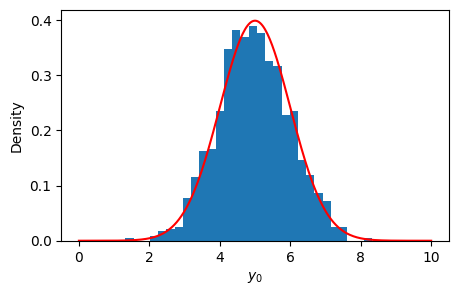

In [17]:
# Task 2
plt.figure(figsize=(5, 3))
plt.hist(y0_samples, 30, density=True, label='histogram') # histogram
y0_mean_theoretical = C @ x0_mean
y0_var_theoretical = C @ x0_var @ C.T + R
xs = np.linspace(0, 10, 300)
plt.plot(xs, stats.norm.pdf(xs, y0_mean_theoretical, np.sqrt(y0_var_theoretical)).T, color='r')
plt.xlabel('$y_0$')
plt.ylabel('Density')
plt.show()

**Task 3.**  When we obtain a sample of the output, $y_0^{(i)}$, we need to estimate the underlying state, $x_0^{(i)}$. To estimate the system state we have two estimators:

   - The conditional expectation $\hat{x}_{0\mid 0}(y_0^{(i)}) = {\rm I\!E}[x_0 {}\mid{} y_0 = y_0^{(i)}]$, in which case the estimation error is $\hat{e}_{0}^{(i)} = x_0^{(i)} - \hat{x}_{0\mid 0}(y_0^{(i)})$
   - The "naive" estimator $\breve{x}_{0\mid 0}(y_0^{(i)}) = \tilde{x}_0$, in which case the estimation error is $\breve{e}_0^{(i)} = x_0^{(i)} - \breve{x}_{0\mid 0}(y_0^{(i)})$

Plot the points $\breve{e}_0^{(i)}$ and $\hat{e}_0^{(i)}$.


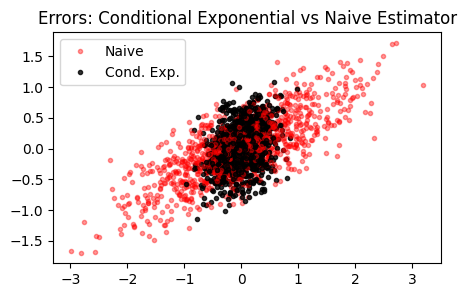

In [18]:
# Task 3
def cond_exp_x0_given_y0(y0):
    return x0_mean + x0_var @ C.T @ np.linalg.solve(C@x0_var@C.T + R, y0 - C@x0_mean)

plt.figure(figsize=(5, 3))
for i in range(N):
    y0i = y0_samples[i]
    x0i = cond_exp_x0_given_y0(y0i)
    ei = x0_samples[i, :] - x0i
    ei_naive = x0_samples[i, :] - x0_mean
    plt.plot(ei_naive[0], ei_naive[1], 'r.', label='Naive' if i==0 else None, alpha=0.4)
    plt.plot(ei[0], ei[1], 'k.', label='Cond. Exp.' if i==0 else None, alpha=0.8)

plt.title('Errors: Conditional Exponential vs Naive Estimator')
plt.legend()
plt.show()

#### Challenge

Consider the random variable $\hat{e}_0 = x_0 - {\rm I\!E}[x_0 {}\mid{} y_0]$. Determine the expectation and variance of $\hat{e}_0$. What is the distribution of $\hat{e}_0$? Plot the distribution of $\hat{e}_0$ using `plot_2d_normal_pdf`.

Repeat for the random variable $\breve{e}_0 = x_0 - \tilde{x}_0$. Compare the two distributions.

### Conclusion

To estimate $x_0$ using the measured output $y_0$ use
$$\hat{x}_{0\mid 0} = \tilde{x}_0 + P_0 C^\intercal (CP_0 C^\intercal + R)^{-1}(y_0 - C\tilde{x}_0),$$
the conditional variance of $x_0$ given $y_0$ is
$$\Sigma_{0\mid 0} = P_0 - P_0C^\intercal (CP_0 C^\intercal + R)^{-1} CP_0.$$
The estimator $\hat{x}_{0\mid 0}$ is an **unbiased minimum variance estimator**!


#### Exercise 2

Obtain a sample of $y_0$ determine $\hat{x}_{0 \mid 0}$ and $\Sigma_{0\mid 0}$. Then plot the distribution of $x_0 \mid y_0$ and compare it to the distribution of $x_0$.



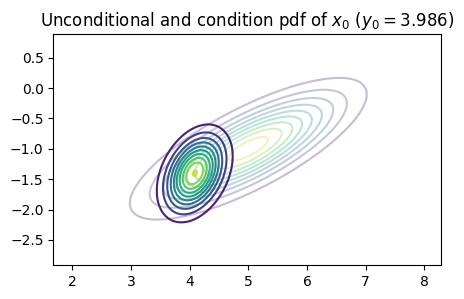

In [19]:
# Exercise 2
plt.figure(figsize=(5, 3))
x0_sample = np.random.multivariate_normal(x0_mean, x0_var, 1).T # sample of x0
v0_sample = np.random.normal(0, np.sqrt(R), 1)
y0_sample = C @ x0_sample + v0_sample
x0_given_y0_mean = cond_exp_x0_given_y0(y0_sample[0])
x0_given_y0_var =  x0_var - x0_var @ C.T @ np.linalg.solve(C@x0_var@C.T + R, C@x0_var)
plot_2d_normal_pdf(x0_mean, x0_var, alpha=0.3) # unconditional pdf
plot_2d_normal_pdf(x0_given_y0_mean, x0_given_y0_var) # conditional pdf
plt.title(f'Unconditional and condition pdf of $x_0$ ($y_0={y0_sample[0,0]:.3f}$)')
plt.show()

### Part 3: Predict $x_1$ given $y_0$

We now want to estimate $x_1$ given the measurement $y_0$. We have
$$\hat{x}_{1\mid 0} = {\rm I\!E}[x_1 {}\mid{} y_0] = {\rm I\!E}[Ax_0 + Gw_0{}\mid{} y_0] = A{\rm I\!E}[x_0 {}\mid{} y_0] = A\hat{x}_{0\mid 0}.$$

The conditional variance of $x_1$ given $y_0$ is
$$\begin{align}
\Sigma_{1\mid 0} = {\rm Var}[x_1 {}\mid{} y_0]
{}={}& {\rm Var}[Ax_0 + Gw_0 {}\mid{} y_0]
 \\
 {}={}& {\rm Var}[Ax_0  {}\mid{} y_0] + {\rm Var}[Gw_0 {}\mid{} y_0]
 \\
 {}={}& ?
\end{align}$$

As a result,
$$x_1 {}\mid{} y_0 \sim \mathcal{N}(?,?)$$


#### Exercise 3

Consider again the same system as in Example 1 above.

Obtain a single sample of $x_0$ and a corresponding sample of $y_0$. Then plot the distribution of $x_1$ given $y_0$. Compare this to the distribution of $x_1$.



[0.775+0.24366986j 0.775-0.24366986j]


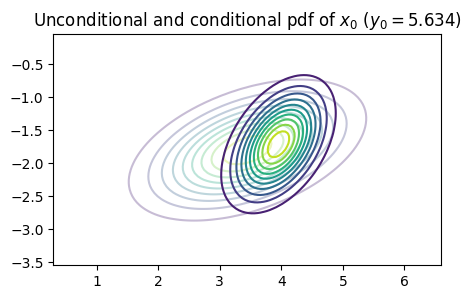

In [20]:
# Task 1A
A = np.array([[0.75, 0.3], [-0.2, 0.8]])
print(np.linalg.eig(A)[0])
Q = np.array([[0.1, 0.05], [0.05, 0.15]])

x0_sample = np.random.multivariate_normal(x0_mean, x0_var, 1).T # sample of x0
v0_sample = np.random.normal(0, np.sqrt(R), 1)
y0_sample = C @ x0_sample + v0_sample
x0_given_y0 = cond_exp_x0_given_y0(y0_sample[0])

x1_given_y0_mean = A @ x0_given_y0
x1_given_y0_var = A @ x0_given_y0_var @ A.T + Q
x1_mean = A @ x0_mean
x1_var = A @ x0_var @ A.T + Q

plt.figure(figsize=(5, 3))
plot_2d_normal_pdf(x1_mean, x1_var, alpha=0.3) # unconditional
plot_2d_normal_pdf(x1_given_y0_mean, x1_given_y0_var) # conditional (given y0)
plt.title(f'Unconditional and conditional pdf of $x_0$ ($y_0={y0_sample[0,0]:.3f}$)')
plt.show()

## Kalman Filter

Congratulations! You have constructed the Kalman Filter! This is what we just did:

- Given $y_0$ we estimated $x_0$, this is $\hat{x}_{0\mid 0} = {\rm I\!E}[x_0 {}\mid{} y_0]$
- and then we predicted $x_{1}$ given $y_0$, this is $x_{1\mid 0}= {\rm I\!E}[x_1 {}\mid{} y_0]$

Once we obtain the measurement $y_1$ we can estimate $x_1$ given $y_1$ *and* $y_0$; this will be the estimate $\hat{x}_{1 {}\mid{} 1} = {\rm I\!E}[x_1 {}\mid{} y_0, y_1]$.

This leads to the KF equations
$$\begin{align*}
    \text{Measurement update} &
    \left[
    \begin{array}{l}
      \hat{x}_{t{}\mid{}t}
      {}={}
      \hat{x}_{t{}\mid{}t-1}
      {}+{}
      \Sigma_{t{}\mid{}t-1}C^\intercal
      (C\Sigma_{t{}\mid{}t-1}C^\intercal + R)^{-1}(y_t - C\hat{x}_{t{}\mid{}t-1})
      \\
      \Sigma_{t{}\mid{}t}
      {}={}
      \Sigma_{t{}\mid{}t-1}
      {}-{}
      \Sigma_{t{}\mid{}t-1}C^\intercal
      (C\Sigma_{t{}\mid{}t-1}C^\intercal + R)^{-1}
      C\Sigma_{t{}\mid{}t-1}
    \end{array}
    \right.
    \\
    \text{Time update}        &
    \left[
    \begin{array}{l}
      \hat{x}_{t+1{}\mid{}t}
      {}={}
      A \hat{x}_{t{}\mid{}t}
      \\
      \Sigma_{t+1{}\mid{}t}
      {}={}
      A \Sigma_{t{}\mid{}t} A^\intercal + GQG^\intercal
    \end{array}
    \right.
    \\
    \text{Initial conditions} &
    \left[
    \begin{array}{l}
      \hat{x}_{0{}\mid{}-1}
      {}={}
      \tilde{x}_0
      \\
      \Sigma_{0{}\mid{}-1}
      {}={}
      P_0
    \end{array}
    \right.
\end{align*}$$

To implement the KF we need to implement two functions:
- The **measurement update** which takes in $\Sigma_{t\mid t-1}$, $\hat{x}_{t\mid t-1}$, and $y_t$ and gives $\Sigma_{t\mid t}$ and $\hat{x}_{t\mid t}$, and
- The **time update** which takes in $\Sigma_{t\mid t}$ and $\hat{x}_{t\mid t}$ and returns $\Sigma_{t + 1\mid t}$ and $\hat{x}_{t + 1\mid t}$

Note that the two functions feed one into the other: the output of the measurement update is fed into the time update function, and the output of the time update function goes into the measurement update function.

#### Exercise 4

Implement the measurement update and time update functions for the above system.

In [21]:
def measurement_update(sigma_tu, x_tu, y):
    z = C @ sigma_tu @ C.T + R # auxiliary variable
    x_mu = x_tu + sigma_tu @ C.T @ np.linalg.solve(z, y - C@x_tu)
    sigma_mu = sigma_tu - sigma_tu @ C.T @ np.linalg.solve(z, C@sigma_tu)
    return sigma_mu, x_mu

def time_update(sigma_mu, x_mu):
    x_tu = A @ x_mu
    sigma_tu = A @ sigma_mu @ A.T + Q
    return sigma_tu, x_tu

Now simulate the system with the Kalman filter

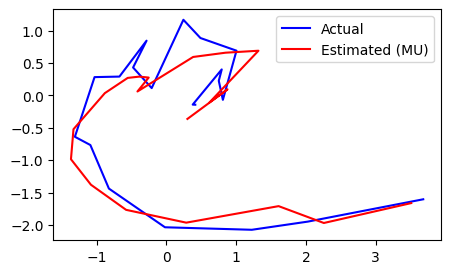

In [22]:
plt.figure(figsize=(5, 3))
n_sim = 20

x = np.random.multivariate_normal(x0_mean, x0_var, 1).T # random initial state
sigma_tu, x_tu = x0_var, x0_mean.reshape((2, 1)) # initialisation

x_cache = np.zeros((n_sim, 2))
x_mu_cache = np.zeros((n_sim-1, 2))
x_cache[0, :] = x.T
for t in range(n_sim - 1):
    # i. Obtain measurement
    v = np.random.normal(0, np.sqrt(R), 1)
    y = C @ x + v

    # ii. Measurement update
    sigma_mu, x_mu = measurement_update(sigma_tu, x_tu, y)
    x_mu_cache[t, :] = x_mu.T

    # iii. Time update
    sigma_tu, x_tu = time_update(sigma_mu, x_mu)
    w = np.random.multivariate_normal([0, 0], Q, 1).T

    # iv. System dynamics
    x = A @ x + w
    x_cache[t+1, :] = x.T


plt.plot(x_cache[:, 0], x_cache[:, 1], 'b-', label='Actual')
plt.plot(x_mu_cache[:, 0], x_mu_cache[:, 1], 'r-', label='Estimated (MU)')
plt.legend()
plt.show()